## HW 2: Feedforward, Gradient Descent, and Backprop

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.display import SVG
import pandas as pd
%matplotlib inline

#### Problem 1. Feedforward

1. Here is a network with two input units, one hidden layer with three hidden units, and a one unit output layer.

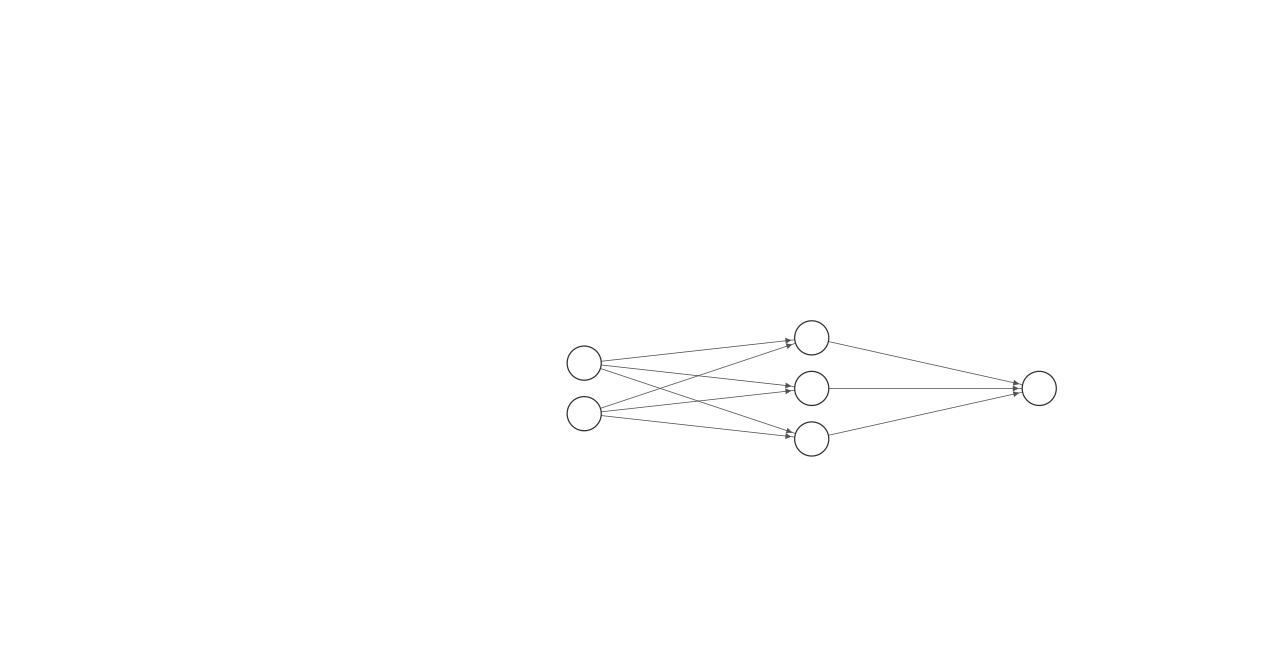

In [2]:
SVG(filename='nn.svg')

2. We write out the mathematical equation for the output of this network below.

In the diagram above, imagine the two input nodes are labeled $x_1$ and $x_2$, the three hidden nodes are $h_1$, $h_2$, and $h_3$, and the output node is $\hat{y}$. The edges from the input layer to the hidden layer are labeled $w_{ij}$ for going from input $x_i$ to hidden node $h_j$, and the edges from the hidden layer to the output layer are $v_j$, from hidden unit $h_j$ to $\hat{y}$. The bias vector for the hidden layer is not shown, nor is the bias constant for the output layer.

Let $h_j = \max(0, a_j)$, where $a_j$ is a weighted sum from the previous layer plus a bias unit. That is,
$$
a_1 = w_{11}x_1 + w_{21}x_2 + b_1 \\
a_2 = w_{12}x_1 + w_{22}x_2 + b_2 \\
a_3 = w_{13}x_1 + w_{23}x_2 + b_3 \\
\Rightarrow a_j = w_{1j}x_1 + w_{2j} + b_j
$$

Similarly,

$$ \hat{y} = g(v_1h_1 + v_2h_2 + v_3h_3 + c), $$
where $g$ is the output function (in this case, for binary classification, $g$ is the sigmoid function). Expanding the above expression to show $\hat{y}$ as a function of all of the variables of the graph, we obtain
$$ \hat{y} = g\big[v_1\max(0, w_{11}x_1 + w_{21}x_2 + b_1) \\ + v_2\max(0, w_{12}x_1 + w_{22}x_2 + b_2) \\ + v_3\max(0, w_{13}x_1 + w_{23}x_2 + b_3) + c\large].$$

We can express this succinctly using matrix notation. If

$$ W = \begin{bmatrix}
w_{11} &w_{12} &w_{13}\\
w_{21} &w_{22} &w_{23}\\
\end{bmatrix}, \hspace{.5cm} \mathbf{x} = \begin{bmatrix} x_1 \\x_2 \end{bmatrix}, \hspace{.5cm} \mathbf{b} = \begin{bmatrix} b_1 \\b_2 \\b_3\end{bmatrix}, \hspace{.5cm} \mathbf{h} = \begin{bmatrix} h_1 \\h_2 \\h_3\end{bmatrix}, \hspace{.5cm} \text{and} \hspace{.5cm} \mathbf{v} = \begin{bmatrix} v_1 \\v_2 \\v_3\end{bmatrix},$$

then
$a_j = W^{T}\mathbf{x} + \mathbf{b}$, $h_j = \max(0, a_j)$, and $\hat{y} = g(\mathbf{v^{T}}\cdot\mathbf{h} + c)$. For binary classification, we have $\hat{y} = \sigma(\mathbf{v^{T}}\cdot\mathbf{h} + c)$.


3. We write out the forward pass function.

In [166]:
sigmoid = lambda x: 1/(1+np.exp(-x))

In [167]:
def ff_nn_ReLu(X, W, v, b, c):
    """ Compute forward pass of network."""
    a = W.T.dot(X) + b
    h = np.maximum(0, a)
    y_hat = sigmoid(v.T.dot(h) + c)
    return y_hat

4. If we have the weight matrices 
$$ W = \begin{bmatrix}
1 &-1 &0\\
0 &0 &0.5\\
\end{bmatrix}, \hspace{.5cm} \mathbf{b} = [0, 0, 1]^T, \hspace{.5cm}, \mathbf{v} = [1, 0, -1]^T, \hspace{.5cm} \text{and} \hspace{.5cm} c = 1,$$ then for the inputs

$$ X = \begin{bmatrix}
1 &-1\\
0 &0\\
0 &1\\
\end{bmatrix}$$
we compute the class probabilities associated with the forward pass for each example below.

In [169]:
X_1 = np.array([1, -1], dtype=np.float32)
X_2 = np.array([0, -1], dtype=np.float32)
X_3 = np.array([0, 1], dtype=np.float32)
W = np.array([[1, -1, 0], [0, 0, 0.5]], dtype=np.float32)
v = np.array([1, 0, -1], dtype=np.float32)
b = np.array([0, 0, 1], dtype=np.float32)
c = 1

In [170]:
print(ff_nn_ReLu(X_1, W, v, b, c))
print(ff_nn_ReLu(X_2, W, v, b, c))
print(ff_nn_ReLu(X_3, W, v, b, c))

0.8175744761936437
0.6224593312018546
0.3775406687981454


In [171]:
X = np.array([[1, -1], [0, -1], [0,1]], dtype=np.float32)

In [172]:
# If X is provided as a single matrix
print(np.apply_along_axis(ff_nn_ReLu, 1, X, W=W, v=v, b=b, c=c))

[0.81757448 0.62245933 0.37754067]


#### Problem 2. Gradient Descent

1. For the function
$$ f(x,y) = (1-x^3) + 100(y^2-x)^2$$
we compute the partial derivatives as
$$ \frac{\partial f}{\partial x}= -3x^2 - 200(y^2 - x)$$
and 
$$ \frac{\partial f}{\partial y}= 400*y(y^2 - x).$$

2. We create a visualization of the contours of $f(x,y)$ below.

In [173]:
def f(x, y):
    return (1 - x**3) + 100 * (y**2 - x)**2

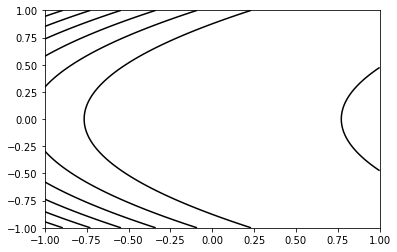

In [180]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
plt.contour(X, Y, Z, colors='black')

3. We write a Gradient Descent algorithm for finding the minimum of the function. We will also visualize results with a few different learning rates.

In [181]:
def grad_f(x, y):
    return -3*x**2 - 200 * (y**2 - x), 400 * y * (y**2 - x)

In [192]:
def grad_descent(x_0, y_0, iters, step_size):
    x = x_0
    y = y_0
    results = [(x, y, f(x, y))]
    for i in range(iters):
        grad_x, grad_y = grad_f(x, y)
        if grad_x < 0:
            dx = step_size
        if grad_y < 0:
            dy = step_size
        if grad_x > 0:
            dx = -step_size
        if grad_y > 0:
            dy = -step_size
        if grad_x == 0:
            dx = 0
        if grad_y == 0:
            dy = 0
        x = x + dx
        y = y + dy
        results.append((x, y, f(x, y)))
    return results

In [193]:
print(grad_descent(-1, 1, 1000, 0.001)[-1])
print(grad_descent(20, 0, 1000, 0.1)[-1])
print(grad_descent(-2, 1, 1000, 0.1)[-1])
print(grad_descent(1, 1, 100, 0.5)[-1])

(8.81239525796218e-16, -8.81239525796218e-16, 1.0)
(-1.529332216421153e-14, 0, 1.0)
(6.38378239159465e-16, 1.3877787807814457e-16, 1.0)
(1.0, 1.5, 156.25)


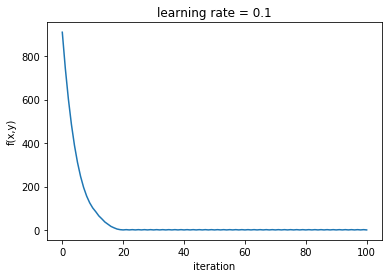

In [231]:
xs = grad_descent(-2, 1, 100, 0.1)
X = [i[0] for i in xs]
Y = [i[2] for i in xs]

plt.xlabel('iteration')
plt.ylabel('x')
plt.plot(Y)
plt.ylabel('f(x,y)')
plt.title('learning rate = 0.1')

plt.show()

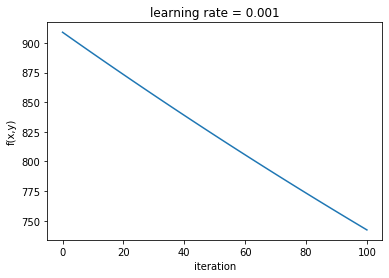

In [232]:
xs = grad_descent(-2, 1, 100, 0.001)
X = [i[0] for i in xs]
Y = [i[2] for i in xs]
#plt.plot(X, '-')
plt.xlabel('iteration')
plt.ylabel('x')
plt.plot(Y)
plt.ylabel('f(x,y)')
plt.title('learning rate = 0.001')

plt.show()

In [224]:
def grad_descent_momentum(x_0, y_0, iters, step_size, initial_velocity=(0,0), alpha=0.01):
    x = x_0
    y = y_0
    v = initial_velocity
    results = [(x, y, f(x, y))]
    for i in range(iters):
        grad_x, grad_y = grad_f(x, y)
        v = alpha * v[0] - step_size*grad_x, alpha * v[1] - step_size*grad_y
        x = x + v[0]
        y = y + v[1]
        results.append((x, y, f(x, y)))
    return results

In [237]:
grad_descent_momentum(1, 1, 100, 0.001, initial_velocity=(0,0), alpha=0.01)

[(1, 1, 0),
 (1.003, 1.0, -0.008127026999999752),
 (1.005448027, 1.0011999999999999, -0.015505116462600327),
 (1.0078959670749945, 1.00243209716176, -0.022959850942678904),
 (1.0103628377861085, 1.0036577048672515, -0.03049124594476472),
 (1.0128431958358153, 1.004888019705669, -0.03810040361325576),
 (1.0153369006967983, 1.0061235785423372, -0.04578835101621155),
 (1.0178441157315659, 1.0073643085556576, -0.053556131687345285),
 (1.020364954697752, 1.0086102397294099, -0.06140480605445895),
 (1.022899529207593, 1.0098614091874143, -0.06933545167610096),
 (1.0254479526049303, 1.0111178533982657, -0.07734916356445869),
 (1.028010339520566, 1.0123796091129418, -0.08544705451905868),
 (1.0305868058496273, 1.0136467134501483, -0.09363025546689188),
 (1.0331774687738238, 1.014919203891381, -0.10189991580997894),
 (1.0357824467797496, 1.0161971182846656, -0.11025720378061232),
 (1.038401859677042, 1.0174804948492668, -0.11870330680445405),
 (1.0410358286168904, 1.018769372180377, -0.12723943

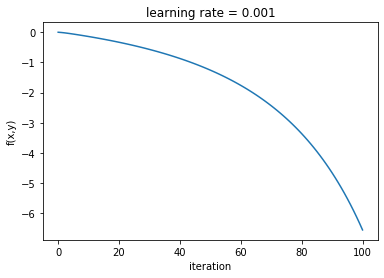

In [245]:
xs = grad_descent_momentum(1, 1, 100, 0.001, initial_velocity=(0,0), alpha=0.5)
X = [i[0] for i in xs]
Y = [i[2] for i in xs]
#plt.plot(X, '-')
plt.xlabel('iteration')
plt.ylabel('x')
plt.plot(Y)
plt.ylabel('f(x,y)')
plt.title('learning rate = 0.001, initial velocity = (0, 0), alpha = 0.5')

plt.show()

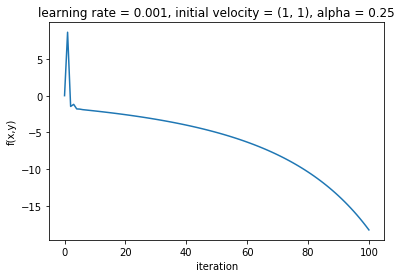

In [246]:
xs = grad_descent_momentum(1, 1, 100, 0.001, initial_velocity=(1,1), alpha=0.25)
X = [i[0] for i in xs]
Y = [i[2] for i in xs]
#plt.plot(X, '-')
plt.xlabel('iteration')
plt.ylabel('x')
plt.plot(Y)
plt.ylabel('f(x,y)')
plt.title('learning rate = 0.001, initial velocity = (1, 1), alpha = 0.25')

plt.show()

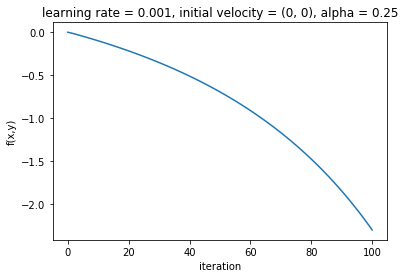

In [247]:
xs = grad_descent_momentum(1, 1, 100, 0.001, initial_velocity=(0,0), alpha=0.25)
X = [i[0] for i in xs]
Y = [i[2] for i in xs]
#plt.plot(X, '-')
plt.xlabel('iteration')
plt.ylabel('x')
plt.plot(Y)
plt.ylabel('f(x,y)')
plt.title('learning rate = 0.001, initial velocity = (0, 0), alpha = 0.25')

plt.show()

#### Problem 3. Backprop

1. Now we derive expressions for the gradient of the loss with respect to each of the model parameters for the network introduced above.


Set as the input into the $j^{\text{th}}$ units of layer $\ell$ 

$$ z_j^\ell = \sum_k w_{jk}^\ell a_k^{\ell-1} + b_j^\ell,$$

where we adopt the same notation as used earlier. So, for instance, the ouptut from unit $j$ in layer $\ell$ is $a_j^l = \text{ReLU}(z_j^l)$.

Further, set the error of neuron $j$ in layer $\ell$ as

$$ \delta_j^\ell = \frac{\partial C}{\partial z_j^\ell},$$

where $C$ is the cost function associated with the task (in this case, binary cross entropy).

Then, for the output layer, say $L$, we have

$$ \delta_j^L = \frac{\partial C}{\partial z_j^\ell} = \frac{\partial C}{\partial \hat{y}_j}  \frac{\partial \hat{y}_j}{\partial a_j^L}  \frac{\partial a_j^L}{\partial z_j^L} = \frac{\partial C}{\partial \hat{y}_j} \cdot 1 \cdot \sigma^\prime(z_j^L).$$

For example, for the output layer in the network above, we have

$$ \delta^3 = \left( \frac{y}{\hat{y}} - \frac{1-y}{1-\hat{y}} \right ) \cdot \sigma^\prime(z^3).$$


The error for any inner layer neuron is

$$ \delta_j^\ell = \frac{\partial C}{\partial z_j^\ell} = \sum_k  \frac{\partial C}{\partial z_j^{\ell+1}} \frac{\partial z_j^{\ell+1}}{\partial a_j^\ell} \frac{\partial a_j^\ell}{\partial z_j^\ell} = (w^{\ell+1})^T \delta^{\ell+1} \odot \text{ReLU}^\prime(z_j),$$

where $\odot$ denotes the Hadamard Product.


For the gradients of the weights, say for $w_{jk}^\ell$ for the weight passing from neuron $k$ to neuron $j$ for layer $\ell$, we compute

$$\frac{\partial C}{\partial w_{jk}^\ell} = \frac{\partial C}{\partial z_j^\ell} \frac{\partial z_j^\ell}{\partial w_{jk}^\ell} = \delta_j^\ell a_k^{\ell-1}.$$

Finally, for the gradients with respect to biases, we have 

$$\frac{\partial C}{\partial b_j^\ell} = \frac{\partial C}{\partial z_j^\ell} \frac{\partial z_j^\ell}{\partial b_j^\ell} = \delta_j^\ell.$$

2. To write a function `grad f(...)` that takes in a weights vector and returns the gradient of the Loss at that location, we create a class, `ANN`, to compute and store the forward pass values and to perform the backprop steps.

In [252]:
sigmoid = lambda x: 1/(1+np.exp(-x))

derivative_of_sigmoid = lambda x: sigmoid(x) * (1-sigmoid(x))

derivative_of_relu = lambda x: (x > 0).astype(float)

class ANN:
    
    def __init__(self):
        self.W = np.random.uniform(low=.1, high=.8, size=(2,3))
        self.v = np.random.uniform(low=.1, high=.8, size=(3,1))
        self.b = np.random.uniform(low=.1, high=.8, size=(3,1))
        self.c = np.random.uniform(low=.1, high=.8, size=())
        
        self.a = None
        self.z_layer2 = None
        self.z = None
        self.yhat = None
        self.y = 1
        self._forward_pass(np.random.uniform(low=.1, high=.8, size=(2,1)), self.y)
        
    def grad_of_loss(self):
        return (np.divide(self.y, self.yhat)) + (np.divide((1-self.y),(1-self.yhat)))

    def _forward_pass(self, X, y):
        self.z_2 = self.W.T.dot(X) + self.b
        self.a = np.maximum(0, self.z_2)
        self.z = self.v.T.dot(self.a) + self.c
        self.yhat = sigmoid(self.z)
        self.y = y
    
    def grad_f(self, X, return_val='w'):
        delta_L = self.grad_of_loss() * derivative_of_sigmoid(self.z)
        delta_2 = self.v.dot(delta_L) * derivative_of_relu(self.z_2)
        
        if return_val == 'v':
            return delta_L * self.a
        if return_val == 'w':
            return delta_2.dot(X.T)
        if return_val == 'b':
            return delta_2
        if return_val == 'c':
            return delta_L
        
    def get_loss(self):
        return np.asscalar(-self.y * np.log(self.yhat) - (1-self.y) * np.log(1-self.yhat))
    
    def grad_descent(self, X, y, iterations=5, learning_rate=0.001): # X is multiple examples
        loss = []
                
        for i in range(iterations): # epochs
            for example, output in zip(np.vsplit(X, X.shape[0]), np.split(y, y.shape[0])):
                self._forward_pass(example.T, output)
                self.v = self.v - learning_rate * self.grad_f(example.T, 'v')
                self.W = self.W - (learning_rate * self.grad_f(example.T, 'w')).T
                self.b = self.b - learning_rate * self.grad_f(example.T, 'b')
                self.c = self.c - learning_rate * self.grad_f(example.T, 'c')
                loss.append(self.get_loss())
        return loss
    
    def predict(self, X): # compute Y | X
        z_2 = self.W.T.dot(X) + self.b
        a = np.maximum(0, z_2)
        z = self.v.T.dot(a) + self.c
        yhat = sigmoid(z)
        return y_hat
    
    def get_y_hats(self, X):
        y_hats = []
        for x in np.vsplit(X, X.shape[0]):
            z_2 = self.W.T.dot(x.T) + self.b
            a = np.maximum(0, z_2)
            z = self.v.T.dot(a) + self.c
            yhat = sigmoid(z)
            y_hats.append(yhat)
        return y_hats
    
    def grad_descent_momentum(self, X, y, iterations=5, learning_rate=0.001,
                              alpha=0.001): # alpha is momentum parameter
        loss = []
        velocity_for_W = np.zeros(shape=self.W.shape)
        velocity_for_v = np.zeros(shape=self.v.shape)
        velocity_for_b = np.zeros(shape=self.b.shape)
        velocity_for_c = np.zeros(shape=self.c.shape)

        for i in range(iterations): # epochs
            for example, output in zip(np.vsplit(X, X.shape[0]), np.split(y, y.shape[0])): # 400 examples
                self._forward_pass(example.T, output)

                velocity_for_v = (velocity_for_v * alpha) - learning_rate * self.grad_f(example.T, 'v')
                velocity_for_W = (velocity_for_W * alpha) - learning_rate * self.grad_f(example.T, 'w').T
                velocity_for_b = (velocity_for_b * alpha) - learning_rate * self.grad_f(example.T, 'b')
                velocity_for_c = (velocity_for_c * alpha) - learning_rate * self.grad_f(example.T, 'c')

                self.v = self.v + velocity_for_v
                self.W = self.W + velocity_for_W
                self.b = self.b + velocity_for_b
                self.c = self.c + velocity_for_c
                
                loss.append(self.get_loss())
        return loss


In [253]:
# Test
network = ANN()
network.grad_f(np.random.uniform(low=.1, high=.8, size=(2,1)), 'w')

array([[0.0602096 , 0.01111895],
       [0.09038765, 0.01669195],
       [0.11959094, 0.02208494]])

3. We generate a synthetic XOR dataset.

//anaconda3/envs/anly590/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


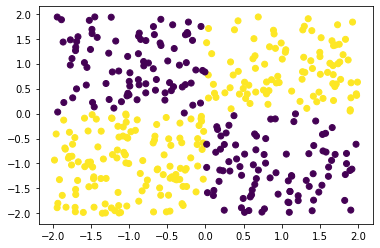

In [292]:
x = np.random.uniform(low=-2, high=2, size=(400,))
y = np.random.uniform(low=-2, high=2, size=(400,))
c = (x < 0) & (y < 0) | (x > 0) & (y > 0)

data = pd.DataFrame({'x': x, 'y': y, 'c' : c})
plt.scatter(data.x, data.y, c=data.c)
data.c[data.c] = 1
data.c[data.c] = 0

4. We fit the network on the data with gradient descent, and we plot the total loss at each iteration.

In [273]:
network = ANN()
network.grad_f(np.random.uniform(low=.1, high=.8, size=(2,1)), 'w')
losses = network.grad_descent(X=data[['x', 'y']].to_numpy(), y=data['c'].to_numpy(), iterations=4, learning_rate=0.001)
losses

//anaconda3/envs/anly590/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


[1.8639735902516905,
 1.1043658350115246,
 2.826280969813652,
 0.4031343593813808,
 2.462982562387276,
 1.3242473688380987,
 1.7650912184551955,
 2.2641881397253933,
 0.06543478724828435,
 0.40438635441181114,
 2.1420209724975634,
 2.396355584373943,
 1.8989437152097863,
 0.40537666996498306,
 0.40002839324311446,
 0.40559767083092474,
 1.2774952742832095,
 2.606942848375806,
 1.4637870234648354,
 0.406515277181914,
 1.287186919531187,
 1.6994805340536745,
 0.08255350476789965,
 1.7995743808099598,
 0.03903635332169063,
 0.07953926080540705,
 2.584139918819181,
 1.2195998504557646,
 1.7344443021743405,
 0.06650396610479904,
 0.4052466982496656,
 1.3576019377168165,
 0.0202795462957845,
 1.2874831047284938,
 1.8664270415582385,
 1.300824000037762,
 0.4094680576088068,
 1.8276430566049962,
 2.153240863331942,
 1.7078486154348522,
 0.036490216051107416,
 1.5422795588609892,
 2.2646040174967728,
 1.5043781250229868,
 0.061506873205085515,
 0.4112969597052815,
 0.07111564778489934,
 1.28248

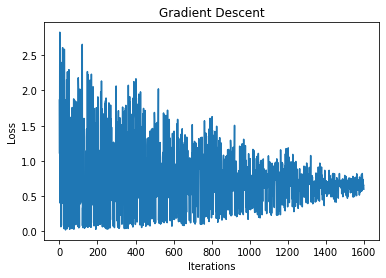

In [280]:
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Gradient Descent')
plt.plot(losses)

5. We repeat the exercise for gradient descent with momentum.

In [277]:
network_momentum = ANN()
network_momentum.grad_f(np.random.uniform(low=.1, high=.8, size=(2,1)), 'w')
losses_momentum = network_momentum.grad_descent_momentum(X=data[['x', 'y']].to_numpy(), y=data['c'].to_numpy(), iterations=4,
                                                         learning_rate=0.001, alpha=0.01)
losses_momentum

//anaconda3/envs/anly590/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


[1.428373393552025,
 0.8578101920383063,
 2.2601958052184945,
 0.5524334817398027,
 1.944225968497763,
 0.9504618365501546,
 1.280961748178005,
 1.69142550117384,
 0.10265712465270356,
 0.5539520466469727,
 1.786601225863271,
 2.051159796039368,
 1.662701717256465,
 0.5552129650064339,
 0.5553979967316605,
 0.5555814790239187,
 1.0341846366547607,
 2.2948380028459185,
 1.1938428757200918,
 0.5397842761806539,
 1.041617107435544,
 1.214239927750227,
 0.12100997839899225,
 1.5342147082848738,
 0.05913734397446274,
 0.12048639482278789,
 2.057798624265719,
 0.8800279062018467,
 1.4222931909824423,
 0.0984068555197379,
 0.558954783264072,
 1.072848081341492,
 0.030679871185199426,
 0.9226715605532442,
 1.2827632282886607,
 0.974935927625459,
 0.5602790900944241,
 1.4852368707506898,
 1.6341659463285274,
 1.2177404692407094,
 0.052883871540873595,
 1.1508791406469032,
 1.7676277886034817,
 1.1524286575182139,
 0.09165111330367814,
 0.5624716465466489,
 0.1135546336202102,
 0.917176074320408

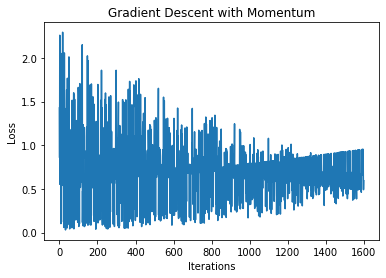

In [279]:
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Gradient Descent with Momentum')
plt.plot(losses_momentum)

We find that momentum converges more efficiently without using momentum. When we did not use momentum, we saw a general trend of decrease in the loss as the algorithm preceeded. With momentum, as shown in the plot above, we actually find the loss decrease and then increase slightly.

6. We plot a visualization of the final decision boundary and overlay it on the XOR dataset.

In [281]:
# plot the decision boundary
# https://chih-ling-hsu.github.io/2017/08/30/NN-XOR
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

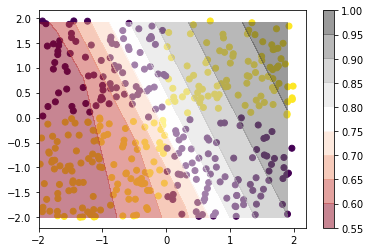

In [305]:
network_graph = ANN()

xx, yy = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = network_graph.get_y_hats(np.c_[xx.ravel(), yy.ravel()])

Z = np.array(Z).reshape(xx.shape)
plt.scatter(data.x, data.y, c=data.c)

plt.contourf(xx, yy, Z, alpha=0.5, cmap='RdGy')
plt.colorbar()

Above, we overlay the decision boundary on the XOR dataset. The colors denote class probabilties. 